In [77]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [78]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = "C:\\Users\\envym\\workplace\\Pneumonia"
TRAIN_PATH = ROOT_PATH + '/chest_xray/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 10

print(ROOT_PATH)

C:\Users\envym\workplace\Pneumonia


In [79]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [80]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [81]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
C:\Users\envym\workplace\Pneumonia\chest_xray\train\NORMAL\NORMAL2-IM-0707-0001.jpeg
Pneumonia image path
C:\Users\envym\workplace\Pneumonia\chest_xray\train\PNEUMONIA\person610_bacteria_2475.jpeg


In [82]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


In [83]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [84]:
TRAIN_IMG_COUNT = len(train_filenames)
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = len(val_filenames)
print(f"Validating images count: {VAL_IMG_COUNT}")


Training images count: 4185
Validating images count: 1047


In [85]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [86]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    label = tf.cast(label, tf.int32)
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [87]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [88]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  0


In [89]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [90]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

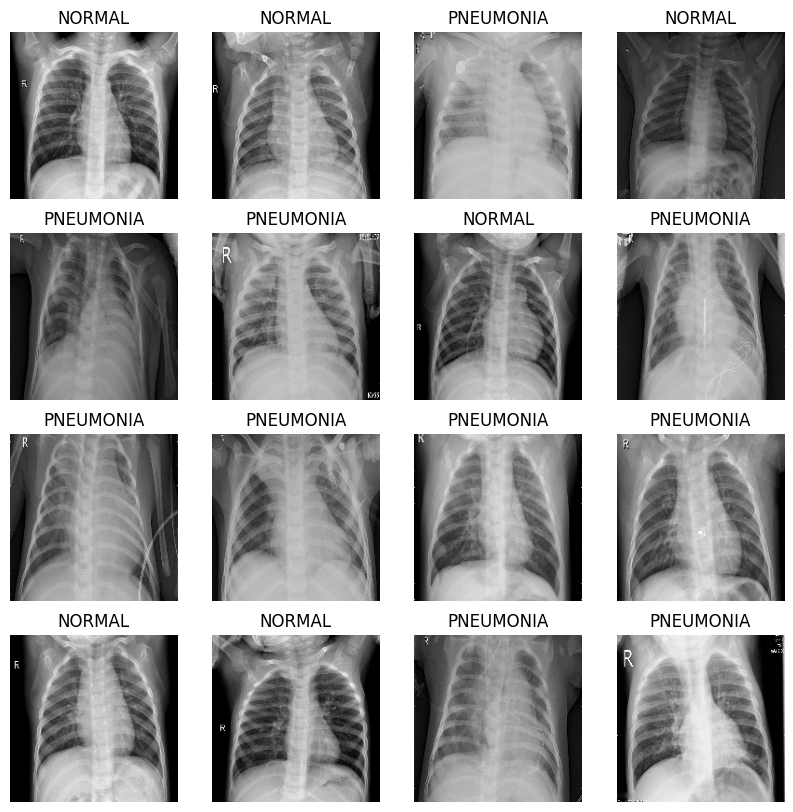

In [91]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

In [92]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [93]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [94]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [95]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


In [96]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [97]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,  # len() 제거
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,  # len() 제거
        class_weight=class_weight,
    )


Epoch 1/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 122s 426ms/step - accuracy: 0.7294 - loss: 0.5015 - precision: 0.9293 - recall: 0.6939 - val_accuracy: 0.7327 - val_loss: 0.6587 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 2/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 106s 407ms/step - accuracy: 0.8961 - loss: 0.2588 - precision: 0.9667 - recall: 0.8906 - val_accuracy: 0.7346 - val_loss: 1.1796 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 104s 400ms/step - accuracy: 0.9167 - loss: 0.2166 - precision: 0.9712 - recall: 0.9151 - val_accuracy: 0.7308 - val_loss: 1.5978 - val_precision: 0.7308 - val_recall: 1.0000
Epoch 4/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 103s 396ms/step - accuracy: 0.9327 - loss: 0.1862 - precision: 0.9768 - recall: 0.9327 - val_accuracy: 0.9115 - val_loss: 0.2045 - val_precision: 0.8936 - val_recall: 0.9987
Epoch 5/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 101s 386ms/step - accuracy: 0.9513 - loss: 0.1387 - precision: 0.9862 - recall: 0.9477 - val_accuracy: 0

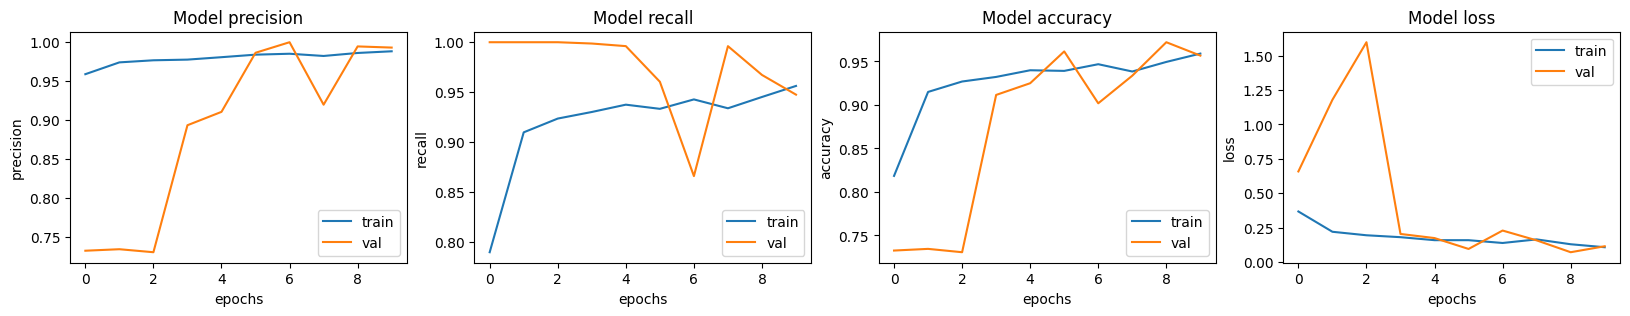

In [98]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [99]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.7986 - loss: 0.7465 - precision: 0.7713 - recall: 0.9638
Loss: 0.785252034664154,
Accuracy: 0.8012820482254028,
Precision: 0.7703251838684082,
Recall: 0.971794843673706
